# Доверительные Интервалы

In [141]:
%matplotlib inline
import matplotlib.pyplot as plt
import scienceplots
from IPython.core.pylabtools import figsize
plt.style.use(['science', 'notebook', 'grid', 'ggplot'])

import numpy as np
import scipy.stats as stats
import scipy

Пусть при решении какой-либо задачи мы получили функцию апостериорного распределения, например мы оценивали $p$ вероятность выпадения орла, обозначим плотность распределения $p$ как $f(p) \sim \mathcal{B}(a,b)$

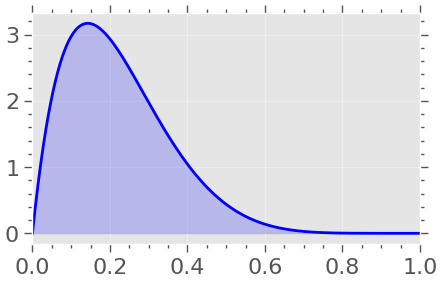

In [142]:
def plot_continuous_dist(x, y, x_lim = (0, 1)):
    plt.figure(figsize=(5,3))
    plt.xlim(x_lim)
    plt.plot(x, y, color='blue')
    plt.fill_between(x, y, color='blue', alpha=0.2)

# Параметры бета-распределения
a, b = 2, 7
x = np.linspace(0,1,1000)
y= stats.beta.pdf(x,a,b)

plot_continuous_dist(x,y)

Как построить хороший доверительный интервал для значения $p$?

Ниже предоставлены 4 различных $80\%$ доверительных интервала для $p$, какой из них будет лучше описывать занчение нашего параметра $p$?

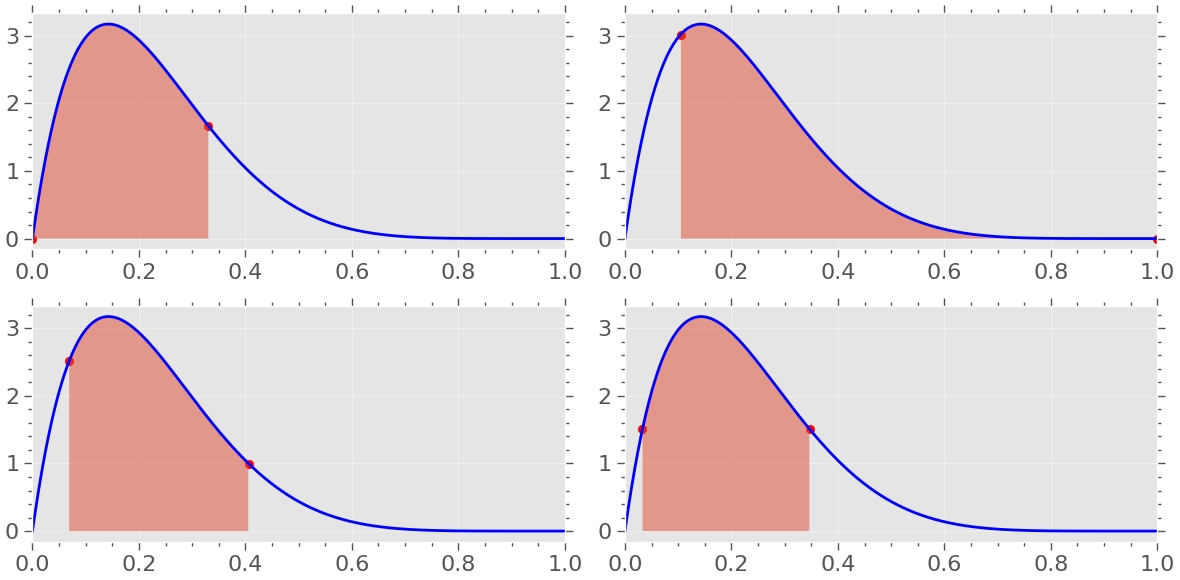

In [143]:
def plot_continuous_dist_interval(x, y,low, high, x_lim=(0, 1), ax=None):
    ax.set_xlim(x_lim)
    ax.plot(x, y, color='blue')
    ax.scatter([low], [y[(np.abs(x - low)).argmin()]], color='red')
    ax.scatter([high], [y[(np.abs(x - high)).argmin()]], color='red')
    ax.fill_between(x, y,where=(x >= low) & (x <= high), alpha=0.5)

# Параметры бета-распределения
a, b = 2, 7
alpha = 0.8
x = np.linspace(0, 1, 1000)
y = stats.beta.pdf(x, a, b)

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

low_1 = 0
high_1 = stats.beta.ppf(alpha, a, b)
plot_continuous_dist_interval(x, y, low_1, high_1, ax=axs[0, 0])

low_2 = stats.beta.ppf(1-alpha, a, b)
high_2 = 1
plot_continuous_dist_interval(x, y, low_2, high_2, ax=axs[0, 1])

low_3, high_3 = stats.beta.interval(alpha, a,b)
# тоже самое что:
# low_3 = stats.beta.ppf((1 - alpha) / 2, a, b)
# high_3 = stats.beta.ppf(1 - (1 - alpha) / 2, a, b)
plot_continuous_dist_interval(x, y, low_3, high_3, ax=axs[1, 0])

low_4, high_4 = (0.03286,0.347066)
plot_continuous_dist_interval(x, y, low_4, high_4, ax=axs[1, 1])

plt.tight_layout()
plt.show()

Если сравнивать интервалы, то второй интервал с длинным хвостом кажется менее предпочтительным по сравнению с остальными, но как это можно формализовать?  
Все интервалы имеют одинаковый уровень доверия в 80%, так что как их можно сравнить между собой?

Один из подходов заключается в выборе интервала с наименьшей длиной, так как это может указывать на более точную оценку. Давайте сравним длины интервалов, чтобы определить, какой из них наиболее подходит.

In [144]:
print(f"Длина интервала 1: {high_1 - low_1}")
print(f"Длина интервала 2: {high_2 - low_2}")
print(f"Длина интервала 3: {high_3 - low_3}")
print(f"Длина интервала 4: {high_4 - low_4}")

Длина интервала 1: 0.3303650322837346
Длина интервала 2: 0.8956271735938672
Длина интервала 3: 0.337619446468102
Длина интервала 4: 0.314206


Как и ожидалось хуже всего себя показал 2 интервал с длинным хвостом, после него идет 3 интервал из библиотеки SciPy (stats.beta.interval(alpha, a,b)), далее идет 1 интервал который начинается в нуле, а лучше всех показал себя 4 интервал с равенством плостности вероятности в концевых точках.  
Является ли 4 интервал минимальным?  

Давайте явно выпишем формулу для доверительного интервала:
Пусть у нас есть доверительный интервал от $[a ,a+l]$ где длинна интервала $l$ фиксирована, попытаемся максимизировать уровень доверия $\alpha$
  
$F(a+l)-F(a)=\alpha$  
где $F(a)$- значение функции распределения в точке $a$  

Дифиренцируем по $a$ тем самым смотрим как значение уровня доверия $\alpha$ будет менятся когда мы будет передвигать точку $a$

$\frac{d}{da}[F(a+l)-F(a)]= \alpha'$  
$f(a+l)-f(a) = \alpha'$  
Приравнивая производную к нулю получаем:  
$f(a+l)=f(a)$  
Таким оброзом уровень доверия при фиксированной длинне интервала, будет максимальным при равенстве плотностей вероятности в концевых точках 

В случае симметричных распределений в том числе нормального, встроенный доверительный интервал stats.norm.interval(alpha) всегда будет минимальной длинны

Найдем интервал минимальной длинны в данной задаче

In [145]:
def minimal_interval(dist, alpha):
    def equations(p):
        x, y = p
        return (dist.pdf(y) - dist.pdf(x), dist.cdf(y) - dist.cdf(x) - alpha)
        
    # Начальное приближение для x и y
    x_guess, y_guess = dist.interval(alpha)
    
    # Решение системы уравнений
    solution = scipy.optimize.fsolve(equations, (x_guess, y_guess))
    return (solution, solution[1]-solution[0])

a, b= (2, 7)
alpha = 0.8
dist = stats.beta(a=a,b=b)
interval, l = minimal_interval(dist, alpha)

print("Интервал минмальной длинны: ", interval)
print("Длинна интервала: ", l)

Интервал минмальной длинны:  [0.03286169 0.34706831]
Длинна интервала:  0.31420661532259186


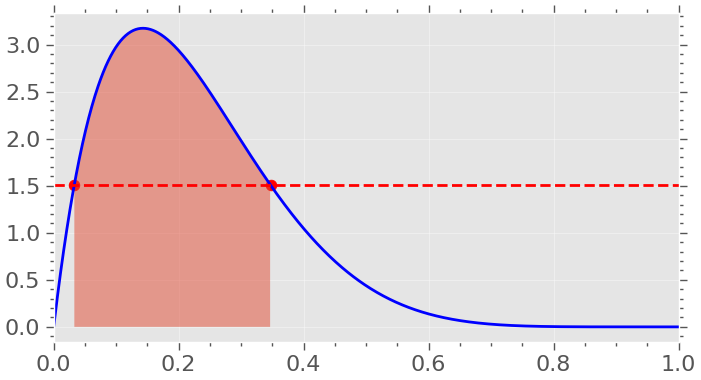

In [146]:
x = np.linspace(0, 1, 1000)
y = dist.pdf(x)
low, high = interval

plt.figure(figsize=(7,4))
plt.xlim((0,1))
plt.plot(x, y, color='blue')
plt.scatter([low], [y[(np.abs(x - low)).argmin()]], color='red', s=60)
plt.scatter([high], [y[(np.abs(x - high)).argmin()]], color='red', s=60)
plt.axhline(y=y[(np.abs(x - high)).argmin()], color='red', linestyle='--')
plt.fill_between(x, y,where=(x >= low) & (x <= high), alpha=0.5)
plt.tight_layout()
plt.show()

Изменяя значение уровня доверия $\alpha$ мы перемещаем горизонтальную прямую.  
Аналогично оптимизацию по нахождению интервала минимальной длинны можно представить как сдвиг горизонтальной прямой $f(p) = c$  
до значения необходимого уровня доверия 

In [ ]:
from ipywidgets import interact, FloatSlider

# Функция для интерактивного обновления результатов
def update_interval(alpha):
    a, b = (2, 7)
    dist = stats.beta(a=a, b=b)
    interval, l = minimal_interval(dist, alpha)
    print("Интервал минимальной длины: ", interval)
    print("Длина интервала: ", l)

    x = np.linspace(0, 1, 1000)
    y = dist.pdf(x)
    low, high = interval
    
    plt.figure(figsize=(7,4))
    plt.xlim((0,1))
    plt.plot(x, y, color='blue')
    plt.scatter([low], [y[(np.abs(x - low)).argmin()]], color='red', s=60)
    plt.scatter([high], [y[(np.abs(x - high)).argmin()]], color='red', s=60)
    plt.axhline(y=y[(np.abs(x - high)).argmin()], color='red', linestyle='--')
    plt.fill_between(x, y,where=(x >= low) & (x <= high), alpha=0.5)
    plt.tight_layout()
    plt.show()



# Создание слайдера для alpha с интерактивным обновлением
interact(update_interval, alpha=FloatSlider(min=0.01, max=0.99, step=0.01, value=0.8));

<img src= "assets\minimal_interval.gif" width="750" align="center" loop="1">

Когда наши данные распределены бимодально все становится сложнее

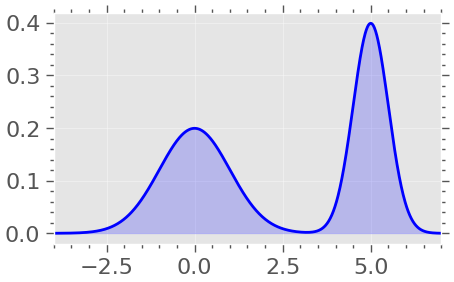

In [13]:
class BimodalDistribution:
    dist_1 = None
    dist_2 = None
    p = 0
    def __init__(self, dist1, dist2, p):
        if not 0 <= p <= 1:
            raise ValueError("Значение p должно быть в диапазоне от 0 до 1")
        self.dist_1= dist1
        self.dist_2 = dist2
        self.p = p

    def pdf(self, x):
        return self.p * self.dist_1.pdf(x) + (1 - self.p) * self.dist_2.pdf(x)

    def cdf(self, x):
        return self.p * self.dist_1.cdf(x) + (1 - self.p) * self.dist_2.cdf(x)

    def ppf(self, q):
        # Находим квантиль численно
        def objective(x):
            return self.cdf(x) - q
        
        result = scipy.optimize.root_scalar(objective, bracket=[self.dist_1.ppf(0.001), self.dist_2.ppf(0.999)], method='brentq')
        return result.root

    def interval(self, alpha):
        # Находим интервал, содержащий заданный процент распределения
        return self.ppf((1 - alpha) / 2), self.ppf((1 + alpha) / 2)

dist = BimodalDistribution(stats.norm(loc = 0, scale = 1), stats.norm(loc = 5, scale = 0.5), 0.5)
x = np.linspace(-4, 7, 1000)
y = dist.pdf(x)

plot_continuous_dist(x,y, x_lim = (-4, 7))

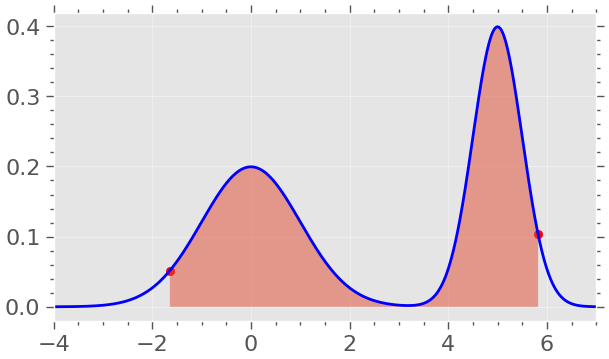

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(7, 4))

alpha = 0.95
low, high = dist.interval(alpha)
plot_continuous_dist_interval(x,y,low,high,x_lim = (-4,7), ax = axs)

На этом графике доверительного интервала видно, что в диапазоне $[2,4]$ плотность распределения практически отсутствует. В такой ситуации можно либо попробовать разделить распределение на два кластера и для каждого из них построить свой доверительный интервал, либо создать доверительный интервал, объединив два интервала, соответствующих каждому из пиков.